## check keras backend to see if GPU is running

In [1]:
import keras
keras.backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

## data pre-process
### labels visulization

Number of Classes in this label image:12,image hight:360,image width:480
minimum label img = 0, maximum label img = 11, Total number of label img classes = 12


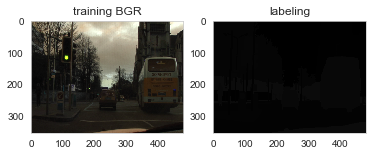

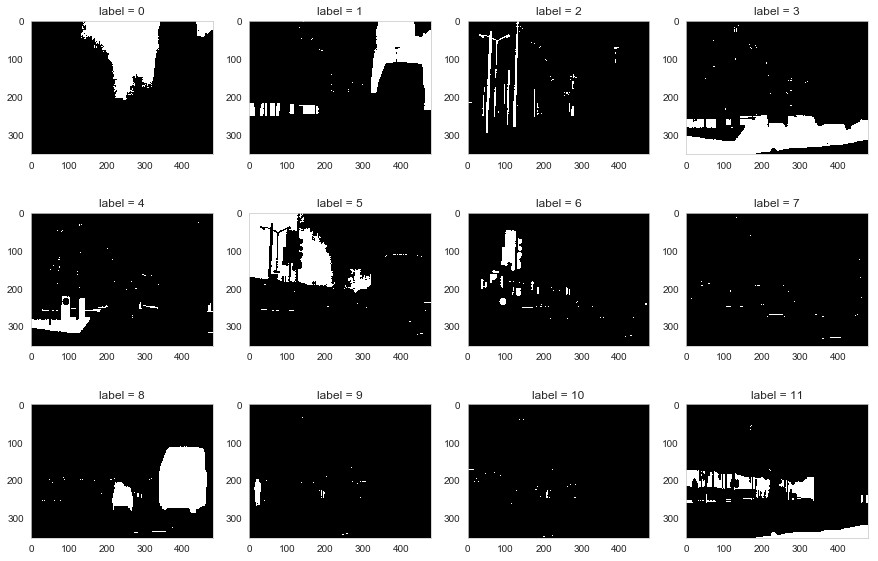

In [13]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

training_image_path = 'dataset/images_prepped_train'
training_label_path = 'dataset/annotations_prepped_train'
trainingFileNameList = os.listdir(training_image_path)
# img_training = mpimg.imread(os.path.join(training_image_path,trainingFileNameList[0]))
img_training = cv2.imread(os.path.join(training_image_path,trainingFileNameList[10]))
labelingFileNameList = os.listdir(training_label_path)
img_labeling = cv2.imread(os.path.join(training_label_path,labelingFileNameList[10]))

rows, cols, chanels = img_labeling.shape

mi, ma = np.min(img_labeling), np.max(img_labeling)
n_classes = ma - mi + 1
print('Number of Classes in this label image:{},image hight:{},image width:{}'.format(n_classes, rows, cols))
print('minimum label img = {}, maximum label img = {}, Total number of label img classes = {}'.format(mi, ma, n_classes))
img_training = cv2.resize(img_training,((cols//32)*32, (rows//32)*32))
img_labeling = cv2.resize(img_labeling,((cols//32)*32, (rows//32)*32))
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('training BGR')
ax1.imshow(img_training)

ax2.set_title('labeling')
ax2.imshow(img_labeling)

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((img_labeling == k)*1.0)
    ax.set_title("label = {}".format(k-mi))
    
plt.show()

### color visualization of labeling image

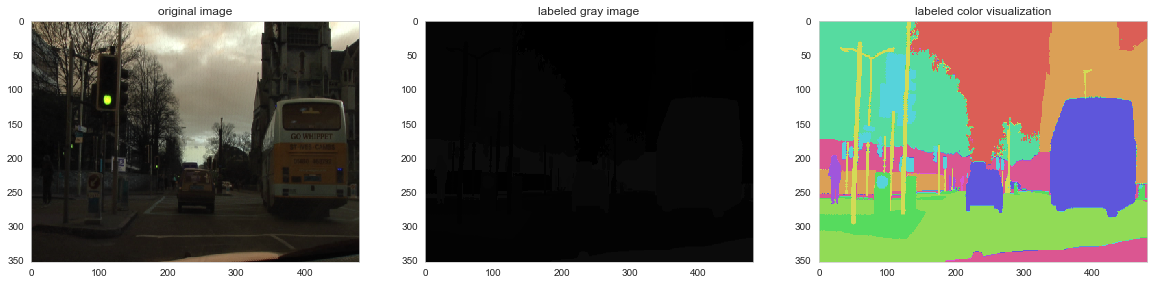

In [3]:
import seaborn as sns
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})

def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)
seg_img = give_color_to_seg_img(img_labeling,n_classes)
fig = plt.figure(figsize=(20,40))
ax = fig.add_subplot(1,3,1)
ax.set_title('original image')
ax.imshow(img_training)
ax = fig.add_subplot(1,3,2)
ax.set_title('labeled gray image')
ax.imshow(img_labeling)
ax = fig.add_subplot(1,3,3)
ax.set_title('labeled color visualization')
ax.imshow(seg_img)

### data prepare

In [4]:
from sklearn.model_selection import train_test_split
import sklearn
def generator(samples, batch_size = 32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            labels = []
            for batch_sample in batch_samples:
                trainPath = os.path.join(training_image_path, batch_sample)
                labelPath = os.path.join(training_label_path, batch_sample)
                img_train = cv2.imread(trainPath)
                img_train = cv2.resize(img_train, ((cols//32)*32, (rows//32)*32))
                
                img_label = cv2.imread(labelPath)
                img_label = cv2.resize(img_label, ((cols//32)*32, (rows//32)*32))
                seg_labels = np.zeros(((rows//32)*32 , (cols//32)*32  , n_classes ))
                img_label = img_label[:, : , 0]

                for c in range(n_classes):
                    seg_labels[: , : , c ] = (img_label == c ).astype(int)
        
                images.append(img_train)
                labels.append(seg_labels)

            x = np.array(images)
            y = np.array(labels)
            yield sklearn.utils.shuffle(x, y)
            

# train_generator = generator(trainingFileNameList, batch_size=32)
train_samples, validation_samples = train_test_split(trainingFileNameList, test_size=0.1)
train_generator = generator(train_samples, batch_size=8)
validation_generator = generator(validation_samples, batch_size=8)

In [ ]:
# from tqdm import tqdm
# import numpy as np
# trainingImgs = []
# labelImgs = []
# for file in tqdm(trainingFileNameList):
#     path = os.path.join(training_image_path, file)
#     img = cv2.imread(path, 1)
#     img_resize = cv2.resize(img, ((cols//32)*32, (rows//32)*32))
#     trainingImgs.append(img_resize)
    
# for file in tqdm(labelingFileNameList):
#     path = os.path.join(training_label_path, file)
#     img = cv2.imread(path, 1)
#     img_resize = cv2.resize(img, ((cols//32)*32, (rows//32)*32))
    
    
#     seg_labels = np.zeros(((rows//32)*32 , (cols//32)*32  , n_classes ))
#     img_resize = img_resize[:, : , 0]
    
#     for c in range(n_classes):
#         seg_labels[: , : , c ] = (img_resize == c ).astype(int)
#     ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
#     labelImgs.append(seg_labels)
    
# assert len(trainingImgs) == len(labelImgs), 'training set and labeling set should be same size.'
# trainingImgs = np.array(trainingImgs)
# labelImgs = np.array(labelImgs)
# print('training image set size:{}, label image set size:{}'.format(trainingImgs.shape, labelImgs.shape))

## Import Keras and Tensorflow to develop deep learning FCN models

In [ ]:
# location of VGG weights
VGG_Weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
from keras.models import *
from keras.layers import *
def FCN8( nClasses, input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0, 'input_height must be devisible by 32 because maxpooling with filter size = (2,2)'
    assert input_width%32 == 0, 'input_width must be devisible by 32 because maxpooling with filter size = (2,2)'
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## image shape
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses = n_classes,  
             input_height = (rows//32)*32, 
             input_width  = (cols//32)*32)
model.summary()

In [6]:
from keras.applications.vgg16 import VGG16
from keras.initializers import Constant
from keras.models import *
from keras.layers import *
def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = factor*2 - factor%2
    factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:filter_size, :filter_size]
    upsample_kernel = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights

def fcn_32s(nClasses, input_height=224, input_width=224):
    img_input = Input(shape=(input_height,input_width, 3)) ## image shape
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=img_input)
    x = Conv2D(filters=nClasses, 
               kernel_size=(1, 1))(vgg16.output)
    x = Conv2DTranspose(filters=nClasses, 
                        kernel_size=(64, 64),
                        strides=(32, 32),
                        padding='same',
                        activation='sigmoid',
                        kernel_initializer=Constant(bilinear_upsample_weights(32, nClasses)))(x)
    model = Model(inputs=img_input, outputs=x)
    for layer in model.layers[:15]:
        layer.trainable = False
    return model

model = fcn_32s(nClasses = n_classes,  
             input_height = (rows//32)*32, 
             input_width  = (cols//32)*32)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 352, 480, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 352, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 352, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 176, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 176, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 176, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 88, 120, 128)      0         
__________

## Train FCN model

In [7]:
from keras import optimizers
sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# model.fit(trainingImgs, labelImgs, validation_split=0.1, shuffle=True, batch_size=32, nb_epoch=5)

hist1 = model.fit_generator(train_generator, 
                    samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), 
                    nb_epoch=1)

model.save('model.h5')
print('model has been saved successfully!')

C:\Users\qwang97\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
C:\Users\qwang97\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=1, validation_data=<generator..., steps_per_epoch=330, validation_steps=37)`
  del sys.path[0]


Epoch 1/1
330/330 [==============================] - 364s 1s/step - loss: 1.5361 - acc: 0.4654 - val_loss: 0.4978 - val_acc: 0.8499
model has been saved successfully!


### Plot the change in loss over epochs

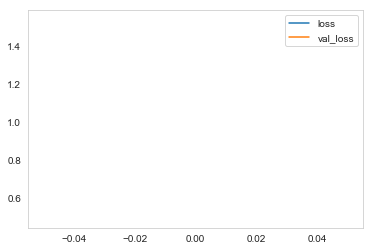

In [8]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

## Evaluate FCN model
### prepare testing data

In [9]:
from tqdm import tqdm

TEST_PATH = 'dataset/images_prepped_test'
TEST_LABEL_PATH = 'dataset/annotations_prepped_test'
X_test = []
y_test = []
# for file in tqdm(os.listdir(TEST_PATH)):
#     path = os.path.join(TEST_PATH, file)
#     img = cv2.imread(path, 1)
#     img = cv2.resize(img, ((cols//32)*32, (rows//32)*32))
#     X_test.append(img)
    
#     path = os.path.join(TEST_LABEL_PATH, file)
#     img = cv2.imread(path, 1)
#     img = cv2.resize(img, ((cols//32)*32, (rows//32)*32))
#     y_test.append(img)

# test 1 image
path = os.path.join(TEST_PATH, os.listdir(TEST_PATH)[0])
img = cv2.imread(path, 1)
img = cv2.resize(img, ((cols//32)*32, (rows//32)*32))
X_test.append(img)

path = os.path.join(TEST_LABEL_PATH, os.listdir(TEST_PATH)[0])
img = cv2.imread(path, 1)
img = cv2.resize(img, ((cols//32)*32, (rows//32)*32))
seg_y = np.zeros(((rows//32)*32 , (cols//32)*32  , n_classes ))
img = img[:, : , 0]

for c in range(n_classes):
    seg_y[: , : , c ] = (img == c ).astype(int)

y_test.append(seg_y)

X_test = np.array(X_test)
y_test = np.array(y_test)

### Calculate intersection over union for each segmentation class

In [10]:
# model1 = load_model('model.h5')
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(1, 352, 480) (1, 352, 480)


In [11]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP= 13850, #FP=  1289, #FN=  624, IoU=0.879
class 01: #TP= 48145, #FP=  3404, #FN= 3405, IoU=0.876
class 02: #TP=     0, #FP=     0, #FN=  544, IoU=0.000
class 03: #TP= 45630, #FP=  1589, #FN= 2566, IoU=0.917
class 04: #TP= 13841, #FP=  3610, #FN= 1034, IoU=0.749
class 05: #TP= 24153, #FP=  2893, #FN=  689, IoU=0.871
class 06: #TP=     0, #FP=     0, #FN=  900, IoU=0.000
class 07: #TP=   904, #FP=   398, #FN= 3103, IoU=0.205
class 08: #TP=  4899, #FP=  2107, #FN= 1034, IoU=0.609
class 09: #TP=     4, #FP=   881, #FN=  905, IoU=0.002
class 10: #TP=   398, #FP=   335, #FN= 1810, IoU=0.157
class 11: #TP=    82, #FP=   548, #FN=  440, IoU=0.077
_________________
Mean IoU: 0.445


## Visualize the model performance

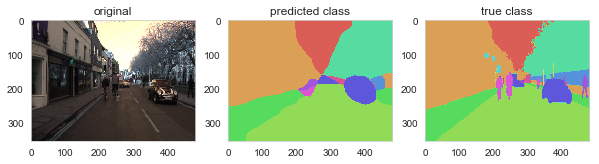

In [12]:
n_classes = 12
for i in range(1):
#     img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
#     ax.imshow(img_is/255.0)
    ax.imshow(X_test[i])
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()